# Workbench

This notebook is intended to test written objects by attempt to build and optimize simple Organic Rankine Cycle (ORC).

Brief description of ORC:

https://en.wikipedia.org/wiki/Organic_Rankine_cycle

In [69]:
# Importing the most important packages
import time
import CoolProp.CoolProp as CP
import pandas as pd
from scipy.optimize import fsolve, fminbound, least_squares, differential_evolution, shgo, brute

# Importing OOPS elements
from OOPS import Turbine, Pump, HeatExchanger

In [2]:
Turbine(T_in = 211.80,p_in = 845,p_out = 20, mf = 0.395, medium = 'Toluene')

# Finding the right `T_hot_out` for heat exchanger
# Method 1 - `while` loop

Checking if it is possible to optimize desired premilimary parameters of heat exchanger using for loop

In [3]:
# Setting flue gas composition
z_CO2 = 0.0670
z_O2  = 0.0610
z_H2O = 0.1310
z_N2  = 0.7410

In [4]:
# Establishing object based on HeatExchanger class. I'm looking for outlet temperature of hotter fluid, 
# so I have to give some placeholder value

test_HE2 = HeatExchanger(T_hot_in = 510, T_hot_out = 100, T_cold_in = 182.24, T_cold_out = 310, 
                                  m_hot = 0.65, m_cold = 0.71895, p_hot_in = 100, p_cold_in = 300, 
                                  hot_fluid = f'HEOS::CO2[{z_CO2}]&O2[{z_O2}]&N2[{z_N2}]&H2O[{z_H2O}]', cold_fluid = 'INCOMP::T66', 
                                  flow_arrangement = 'counter')

In [5]:
# Check if parameters are in place
test_HE2.T_hot_out

100

In [6]:
# Calculating - first attempt
test_HE2.calc_temp_dist()

In [7]:
# Calculating satyration temperature of flue gas - this is lower bound of the T_hot_out temperature
T_dp = CP.PropsSI('T', 'Q', 1.0, 'P', test_HE2.p_hot_in*1000, test_HE2.hot_fluid)-273.15
T_dp

51.146850664248575

In [8]:
# Checking the value of dT_min
test_HE2.dT_min

-21.663065238738284

Text(0.5, 1.0, 'Test HE2')

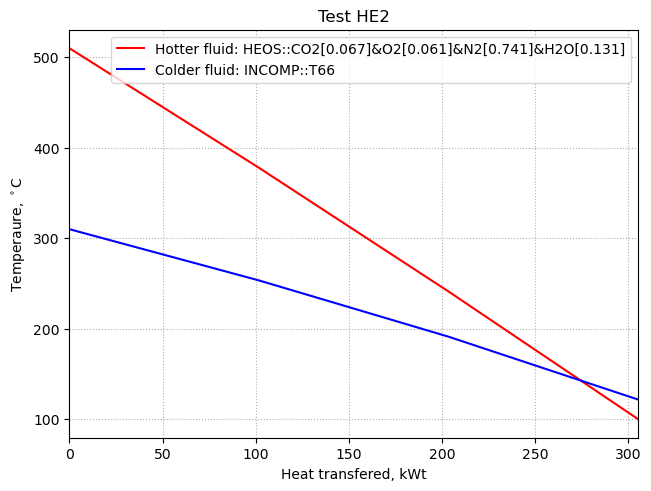

In [9]:
# Let's check how it looks on a diagram
test_HE2_fig, test_HE2_ax = test_HE2.plot_temp_dist_df()
test_HE2_ax.set_title('Test HE2')

The value of `dT_min` is rubbish - thats OK ;) for now. Now I need to find `T_hot_out` using `while` loop.  
From the diagram it is visible that `T_hot_out` should go up for `dT_min` to be positive in the first place and then to reach desired 40 C.deg 

In [10]:
start_time = time.time()

while round(test_HE2.dT_min,2) != 40:
    
    test_HE2.T_hot_out = test_HE2.T_hot_out+0.01
    test_HE2.calc_temp_dist()
    test_HE2.dT_min
    print(test_HE2.T_hot_out, test_HE2.dT_min, end="\r")

end_time = time.time()

In [11]:
# How long did it take?
hours, rem = divmod(end_time-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:03:54.84


Text(0.5, 1.0, 'Test HE2')

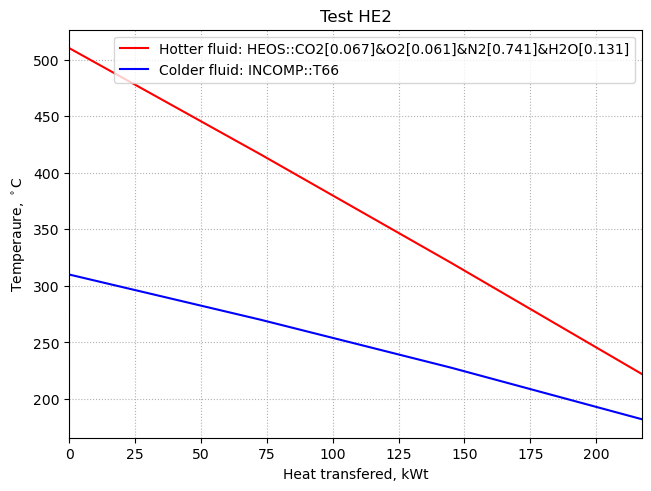

In [12]:
# Now let's chec the diagram again 
# Let's check how it looks on a diagram
test_HE2_fig, test_HE2_ax = test_HE2.plot_temp_dist_df()
test_HE2_ax.set_title('Test HE2')

So it is possible to find the right `T_hot_out` using while loop, although it takes some time. There has to be other, faster method to do the same calculations eg. usning *SciPy* package.

# Finding the right `T_hot_out` for heat exchanger
# Method 2 - wrapper function

Method 1 is simple but takes a lot of time.

It also requires to know if step value should be added or subtracted. In theory is should be easy to fix with simple `if` statement, but in reality cases with phase change will make it much more tricky.

Method 2 uses **simple wrapper function** of object to make it possible to combine with *SciPy* packgage.

In [13]:
# First lets define new object, to not interfere with calulations for Method 1

test_HE3 = HeatExchanger(T_hot_in = 510, T_hot_out = 100, T_cold_in = 182.24, T_cold_out = 310, 
                                  m_hot = 0.65, m_cold = 0.71895, p_hot_in = 100, p_cold_in = 300, 
                                  hot_fluid = f'HEOS::CO2[{z_CO2}]&O2[{z_O2}]&N2[{z_N2}]&H2O[{z_H2O}]', cold_fluid = 'INCOMP::T66', 
                                  flow_arrangement = 'counter')

In [14]:
# Wrapper for SciPy

def solve_T_hot_out(T_hot_out, dT_min, Object):
    
    """
    T_hot_out - temperature of hotter fluid at heat exchanger outlet to be found, C
    dT_min - desired design value of minimal temperature difference in heat exchanger, C
    Object - object to be updated during calculations in function
    """
    
    test_HE3.T_hot_out = T_hot_out
    test_HE3.calc_temp_dist()
    
    return test_HE3.dT_min - dT_min #The difference between this two values should be 0
    

In [15]:
# Finding the reight outlet temperature of hotter fluid T_hot_out
start_time = time.time()

T_hot_out = least_squares(fun=solve_T_hot_out, x0=100, bounds = (T_dp, test_HE3.T_hot_in), args = ([40,test_HE3]))

end_time = time.time()

In [16]:
# How long did it take?
hours, rem = divmod(end_time-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:00:00.23


In [17]:
# Compare resulst from method 1 and 2
print('Method 1: ', test_HE2.T_hot_out, ' Method 2: ', T_hot_out.x)

Method 1:  222.2399999999286  Method 2:  [222.24012597]


In [18]:
test_HE3.dT_min

40.000001735197884

There is slight difference, but for industrial applications the difference at the second decimal is negletible. The most important part is that calcualtions using method 2 are much faster - the result is obtained almost instantly

Text(0.5, 1.0, 'Test HE3')

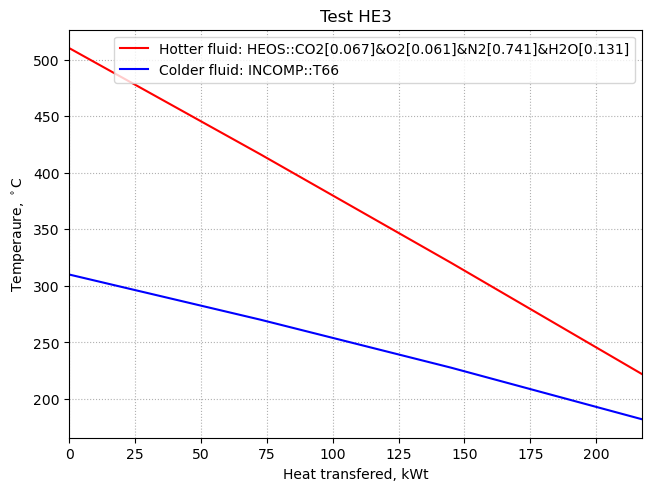

In [19]:
# Now let's chec the diagram
test_HE3_fig, test_HE3_ax = test_HE3.plot_temp_dist_df()
test_HE3_ax.set_title('Test HE3')

# Method 3

Is there a way to write method for object that would be feasible for any SciPy funtions?

# Finding the right mf for heat exchanger

I need to find working fluid mass flow, according to desired dT_min and mimal temperature of heat source at heat exchnager (evaporator) outlet.

In [20]:
def solve_by_mass(guess, dT_min, heat_exchanger):

    """
    mf              - mass floww of working fluid, kg/s
    dT_min          - desired design value of minimal temperature difference in heat exchanger, C
    heat_exchanger  - object representing heat exchanger in ORC system to be updated during calculations in function
    """
    
    T_hot_out = guess[0]
    mf = guess[1]

    heat_exchanger.T_hot_out = T_hot_out
    heat_exchanger.m_cold = mf
    heat_exchanger.calc_temp_dist(points = 30)
    dQ = heat_exchanger.Q_hot - heat_exchanger.Q_cold
    dT = heat_exchanger.dT_min - dT_min
    
    roots = [dQ, dT]
    
    return roots

In [21]:
test_HE4 = HeatExchanger(T_hot_in = 510, T_hot_out = 100, T_cold_in = 57.95024173613791, T_cold_out = 247.64363507859628, 
                                  m_hot = 0.65, m_cold = 0.65, p_hot_in = 101.325, p_cold_in = 300, 
                                  hot_fluid = f'HEOS::CO2[{z_CO2}]&O2[{z_O2}]&N2[{z_N2}]&H2O[{z_H2O}]', cold_fluid = 'Toluene', 
                                  flow_arrangement = 'counter')

Text(0.5, 1.0, 'Test HE4')

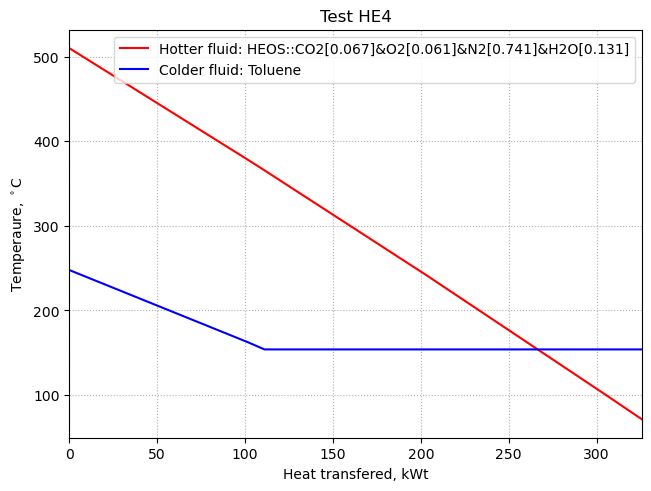

In [22]:
test_HE4.calc_temp_dist()
test_HE4_fig, test_HE4_ax = test_HE4.plot_temp_dist_df()
test_HE4_ax.set_title('Test HE4')

In [23]:
guess = [510, 0.55]
lower_bounds = [125.0, 0.0]
upper_bounds = [510, 1]
res = least_squares(fun=solve_by_mass, x0=guess, bounds = (lower_bounds,upper_bounds), args = (80,test_HE4)).x

In [24]:
guess[1]

0.55

In [25]:
res

array([137.94459157,   0.40228163])

In [26]:
test_HE4.dT_min

79.99998585540129

Text(0.5, 1.0, 'Test HE4')

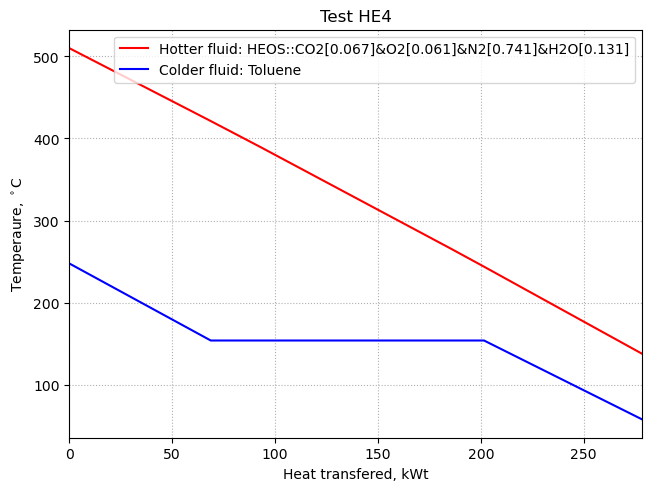

In [27]:
test_HE4.calc_temp_dist()
test_HE4_fig, test_HE4_ax = test_HE4.plot_temp_dist_df()
test_HE4_ax.set_title('Test HE4')

# Building of simple ORC

I'm going to write ORC as object - if succesful it will be a predefined power system in OOPS.

Let's start from checking if tehere is avaliable data for Toluene at pressure `p_max`. It can be done by checking saturation temperature for pressure `p_max`.

This is an easy way to calculate temperature at evaporator colder outlet - `T_hot_out`

In [28]:
CP.PhaseSI('T', 203+273.15, 'P', 700*1000, 'Toluene')

'gas'

In [29]:
CP.PhaseSI('T', 471.1898116, 'P', 724363, 'Toluene')

'unknown: Saturation pressure [724363 Pa] corresponding to T [471.19 K] is within 1e-4 % of given p [724363 Pa] : PropsSI("Phase","T",471.1898116,"P",724363,"Toluene")'

In [30]:
bug = CP.PropsSI('Q','T', 471.1898116, 'P', 724363, 'Toluene')

ValueError: Saturation pressure [724363 Pa] corresponding to T [471.19 K] is within 1e-4 % of given p [724363 Pa] : PropsSI("Q","T",471.1898116,"P",724363,"Toluene")

In [46]:
CP.PropsSI('Q','T', 471.1898116, 'P', 724363, 'Toluene')

ValueError: Saturation pressure [724363 Pa] corresponding to T [471.19 K] is within 1e-4 % of given p [724363 Pa] : PropsSI("Q","T",471.1898116,"P",724363,"Toluene")

In [60]:
CP.PropsSI('Q','T', 471.1898116, 'P', 724363, 'Toluene')

ValueError: Saturation pressure [724363 Pa] corresponding to T [471.19 K] is within 1e-4 % of given p [724363 Pa] : PropsSI("Q","T",471.1898116,"P",724363,"Toluene")

In [61]:
CP.PropsSI('Hmass','T', 471.1898116, 'P', 724363, 'Toluene')/1000

ValueError: Saturation pressure [724363 Pa] corresponding to T [471.19 K] is within 1e-4 % of given p [724363 Pa] : PropsSI("Hmass","T",471.1898116,"P",724363,"Toluene")

In [59]:
CP.PhaseSI('T', 471.19, 'P', 724363, 'Toluene')

'gas'

In [58]:
CP.PhaseSI('Hmass', 483.40669951360974*1000, 'P', 724363, 'Toluene')

'gas'

In [53]:
T_test = 471.189811

try:
    phase = CP.PhaseSI('T', 471.1898116, 'P', 724363, 'Toluene')
    print('no phase change')
except ValueError:

    print('phase_change')

TypeError: PhaseSI() takes exactly 5 positional arguments (6 given)

In [50]:
type(phase)

str

In [40]:
phase

'unknown: Saturation pressure [724363 Pa] corresponding to T [471.19 K] is within 1e-4 % of given p [724363 Pa] : PropsSI("Phase","T",471.1898116,"P",724363,"Toluene")'

In [56]:
if type(phase) == str:
    print('chuj')

chuj


In [62]:
CP.PhaseSI('P',101325,'Q',0,'Water')

'twophase'

In [63]:
CP.PropsSI('Q','T', 15+273.15, 'P', 101.325, 'Water')

-1.0

In [95]:
Q = [0.0, 4.5377673132413205, 30.950035807773556, 61.90007161554711, 92.85010742332067, 123.80014323109422, 141.78174449332926, 154.75017903886777, 185.70021484664133, 216.6502506544149, 247.60028646218845, 278.550322269962]
T_hot = [509.99999076971966, 504.19822115026085, 470.26289324307123, 430.1271703578778, 389.5783538015026, 348.6052675949425, 324.60279578919227, 307.2015937988098, 265.3674733270214, 223.11114186820345, 180.45060091480724, 137.41532389993682]
T_cold = [203.03978201395864, 198.039811583473, 198.039811583473, 198.039811583473, 198.039811583473, 198.039811583473, 198.039811583473, 186.23013066430315, 156.8622707637267, 125.7458772465103, 92.68944502246552, 57.4149601997957]
Q_hot = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Q_cold = [2.0, 1.0, 0.8075524402803137, 0.5820413727369873, 0.3565303051936611, 0.13101923765033463, 1.349300517136877e-16, -1.0, -1.0, -1.0, -1.0, -1.0]
phase_hot_fluid = ['gas', 'gas', 'gas', 'gas', 'gas', 'gas', 'gas', 'gas', 'gas', 'gas', 'gas', 'gas']
phase_cold_fluid = ['gas', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid']

In [96]:
dict = {
        'Q' : Q,
        'T_hot' : T_hot,
        'T_cold': T_cold,
        'Q_hot' : Q_hot,
        'Q_cold': Q_cold,
        'phase_hot_fluid': phase_hot_fluid,
        'phase_cold_fluid': phase_cold_fluid
        }

In [97]:
table = pd.DataFrame.from_dict(dict)

In [98]:
table

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,0.000000,509.999991,203.039782,1.0,2.000000e+00,gas,gas
1,4.537767,504.198221,198.039812,1.0,1.000000e+00,gas,twophase
2,30.950036,470.262893,198.039812,1.0,8.075524e-01,gas,twophase
3,61.900072,430.127170,198.039812,1.0,5.820414e-01,gas,twophase
4,92.850107,389.578354,198.039812,1.0,3.565303e-01,gas,twophase
5,123.800143,348.605268,198.039812,1.0,1.310192e-01,gas,twophase
6,141.781744,324.602796,198.039812,1.0,1.349301e-16,gas,twophase
7,154.750179,307.201594,186.230131,1.0,-1.000000e+00,gas,liquid
8,185.700215,265.367473,156.862271,1.0,-1.000000e+00,gas,liquid
9,216.650251,223.111142,125.745877,1.0,-1.000000e+00,gas,liquid


# Question: How to split this section into three parts to valculate LMTD?

1. Is is sufiecient to have only three states: gas, liquid and twophase? Isn't it better to include saturated liquid and dry vapour?

In [139]:
superheater = table[(table.Q_cold >=1.0)].iloc[[0, -1]].reset_index(drop=True)
evaporator = table[(table.Q_cold.between(0.0,1.0))].iloc[[0, -1]].reset_index(drop=True)
preheater = table[(table.Q_cold <= min(evaporator.Q_cold))].iloc[[0, -1]].reset_index(drop=True)

In [140]:
superheater

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,0.000000,509.999991,203.039782,1.0,2.0,gas,gas
1,4.537767,504.198221,198.039812,1.0,1.0,gas,twophase


In [141]:
evaporator

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,4.537767,504.198221,198.039812,1.0,1.000000e+00,gas,twophase
1,141.781744,324.602796,198.039812,1.0,1.349301e-16,gas,twophase


In [142]:
preheater

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,141.781744,324.602796,198.039812,1.0,1.349301e-16,gas,twophase
1,278.550322,137.415324,57.414960,1.0,-1.000000e+00,gas,liquid


In [156]:
Q = [0.0, 20.326169611690588, 24.897739724429133, 40.652339223381176, 60.978508835071764, 81.30467844676235, 101.63084805845294, 121.95701767014353, 142.2831872818341, 162.6093568935247, 179.3452818725031, 182.93552650521528]
T_hot = [107.94999999999999, 70.82136725196261, 61.924036982569646, 61.924036982569646, 61.924036982569646, 61.924036982569646, 61.924036982569646, 61.924036982569646, 61.924036982569646, 61.924036982569646, 61.924036982569646, 56.92000000000098]
T_cold = [56.10000000000002, 52.68969266072463, 51.92112527242614, 49.26802719060595, 45.83468433524666, 42.389340053958506, 38.93166531496257, 35.4613258860814, 31.977982120717854, 28.481288738916817, 25.591953246832645, 24.970894603308693]
Q_hot = [2.0, 2.0, 1.0, 0.8979938477502762, 0.7663881949247803, 0.6347825420992843, 0.5031768892737883, 0.37157123644829226, 0.23996558362279635, 0.10835993079730032, 1.0098003068779328e-16, -1.0]
Q_cold = [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
phase_hot_fluid = ['gas', 'gas', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'twophase', 'liquid']
phase_cold_fluid = ['liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid', 'liquid']

In [157]:
dict2 = {
        'Q' : Q,
        'T_hot' : T_hot,
        'T_cold': T_cold,
        'Q_hot' : Q_hot,
        'Q_cold': Q_cold,
        'phase_hot_fluid': phase_hot_fluid,
        'phase_cold_fluid': phase_cold_fluid
        }

table2 = pd.DataFrame.from_dict(dict2)
table2

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,0.000000,107.950000,56.100000,2.000000e+00,-1.0,gas,liquid
1,20.326170,70.821367,52.689693,2.000000e+00,-1.0,gas,liquid
2,24.897740,61.924037,51.921125,1.000000e+00,-1.0,twophase,liquid
3,40.652339,61.924037,49.268027,8.979938e-01,-1.0,twophase,liquid
4,60.978509,61.924037,45.834684,7.663882e-01,-1.0,twophase,liquid
5,81.304678,61.924037,42.389340,6.347825e-01,-1.0,twophase,liquid
6,101.630848,61.924037,38.931665,5.031769e-01,-1.0,twophase,liquid
7,121.957018,61.924037,35.461326,3.715712e-01,-1.0,twophase,liquid
8,142.283187,61.924037,31.977982,2.399656e-01,-1.0,twophase,liquid
9,162.609357,61.924037,28.481289,1.083599e-01,-1.0,twophase,liquid


In [162]:
coller = table2[(table2.Q_hot >=1.0)].iloc[[0, -1]].reset_index(drop=True)
condenser = table2[(table2.Q_hot.between(0.0,1.0))].iloc[[0, -1]].reset_index(drop=True)
subcoller = table2[(table2.Q_hot <= min(condenser.Q_hot))].iloc[[0, -1]].reset_index(drop=True)

In [163]:
coller

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,0.00000,107.950000,56.100000,2.0,-1.0,gas,liquid
1,24.89774,61.924037,51.921125,1.0,-1.0,twophase,liquid


In [164]:
condenser

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,24.897740,61.924037,51.921125,1.000000e+00,-1.0,twophase,liquid
1,179.345282,61.924037,25.591953,1.009800e-16,-1.0,twophase,liquid


In [165]:
subcoller

,Q,T_hot,T_cold,Q_hot,Q_cold,phase_hot_fluid,phase_cold_fluid
0,179.345282,61.924037,25.591953,1.009800e-16,-1.0,twophase,liquid
1,182.935527,56.920000,24.970895,-1.000000e+00,-1.0,liquid,liquid
